In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import sys
from embeddings.seq2tensor import s2t
import tensorflow as tf



print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, add
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.layers import Concatenate, concatenate, subtract, multiply
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import GRU, Input

from tensorflow.keras.optimizers import Adam,  RMSprop

import os
import datetime
import numpy as np
from tqdm import tqdm
import gc

#from tensorflow.compat.v1.keras.layers import Input, GRU
from numpy import linalg as LA
import scipy

# Note: if you use another PPI dataset, this needs to be changed to a corresponding dictionary file.
# id2seq_file = './yeast/preprocessed/protein.dictionary.tsv'

id2seq_file = './sun/preprocessed/SEQ-Supp-ABCD.tsv'
id2index = {}
seqs = []
index = 0
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1
seq_array = []
id2_aid = {}
sid = 0

seq_size = 600
emb_files = ['./embeddings/physio.txt', './embeddings/string_vec7.txt', './embeddings/CTCoding_onehot.txt', './embeddings/vec7_CTC.txt']
use_emb = 3
hidden_dim = 75
n_epochs=130

2.6.0


In [2]:
# ds_file, label_index, rst_file, use_emb, hidden_dim
# ds_file = './yeast/preprocessed/protein.actions.tsv'
ds_file = './sun/preprocessed/Supp-AB.tsv'
label_index = 2
rst_file = 'results/15k_onehot_cnn.txt'
sid1_index = 0
sid2_index = 1

seq2t = s2t(emb_files[use_emb])

In [3]:
max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = True
x = None
count = 0

In [4]:
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break
print (len(raw_data))

73109it [00:00, 361596.86it/s]

73108


In [5]:
len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
print (avg_m_seq, max_m_seq)

2 1


In [6]:
dim = seq2t.dim
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])
print(seq_index1[:10])
print(dim)

100%|███████████████████████████████████████████████████████████████████████| 73108/73108 [00:00<00:00, 4058033.39it/s]

[ 0  2  4  6  8 10 12 14 16 18]
15


In [7]:
class_map = {'0':1,'1':0}
print(class_map)
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1.


{'0': 1, '1': 0}


In [8]:
#WAVELET CODE
#emb_files = ['/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/physio.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/string_vec5.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/CTCoding_onehot.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/vec7_CTC.txt']
use_emb = 1
seq2t_W = s2t(emb_files[use_emb])

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = True
x = None
count = 0

for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break
print (len(raw_data))

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
print (avg_m_seq, max_m_seq)
# dim = seq2t_W.dim
seq_tensor_W = np.array([seq2t_W.embed_normalized(line, seq_size) for line in tqdm(seq_array)])
#seq_tensor_W = np.array([seq2t_W.embed(line) for line in tqdm(seq_array)])
print(seq_tensor_W.shape[1]/20)
seq_tensor_W[0][0]
#seq_tensor_W[i].shape[0]%20

73109it [00:00, 589056.05it/s]


73108
2 1


100%|██████████████████████████████████████████████████████████████████████████| 10364/10364 [00:02<00:00, 3982.53it/s]


30.0


array([-0.526876  , -0.41989842, -0.7306472 ,  0.56317556,  0.07056641,
       -0.09104714,  0.34038082])

In [9]:
#Wavelet feature generation
import pywt
import pywt.data
import scipy.special as special
from scipy.stats import entropy
from scipy.stats import linregress
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import moment
import pandas

#15 filters

coeffs = []

counter = -1

T_W = np.zeros((seq_tensor_W.shape[0],24,28))
for filter in ['db2','db3' ,'db4','db5','db6','db7','db8','db9',
               'bior1.3','bior1.5','bior2.2','bior2.4','bior2.6','bior3.1','bior3.3','bior3.5','bior3.7','bior4.4','bior5.5',
               'coif1','coif2','coif3','coif4','coif5']:
    print("Generating Features For ",filter, " Filter bank started")
    counter = counter + 1
    for i in range(seq_tensor_W.shape[0]):
            #if len(twoD_feature_of_Amino_acides_before_wavelet_transform) != 0:

                
                coeffs = pywt.dwt2(seq_tensor_W[i], filter)
                # LL, (LH, HL, HH),(LH1,HL1,HH1),(LH2, HL2, HH2),(LH3, HL3, HH3) = coeffs
                LL, (LH, HL, HH) = coeffs # separate the Approximate coefficient and detail coefficient to 4 signals

               #generating the criteria including max, min, median, average, Standard deviation,energy, entopy,
               #slope and SED error for details coeeficient towards approximate coefficient
               #overal energy and wavelength for overal signal and write in the file for each filter bank
                LLenergy = np.sqrt(np.sum(np.array(LL[-1]) ** 2)) / len(LL[-1])
                LHenergy = np.sqrt(np.sum(np.array(LH[-1]) ** 2)) / len(LH[-1])
                HLenergy = np.sqrt(np.sum(np.array(HL[-1]) ** 2)) / len(HL[-1])
                HHenergy = np.sqrt(np.sum(np.array(HH[-1]) ** 2)) / len(HH[-1])
                overalEnergy = np.sqrt(np.sum(np.array(coeffs[-1]) ** 2)) / len(coeffs[-1])
                LLwavelength = len(LL)

                LL = np.concatenate(LL)
                LH = np.concatenate(LH)
                HL = np.concatenate(HL)
                HH = np.concatenate(HH)

                LL1energy = np.sqrt(np.sum(np.array(LL[-1]) ** 2)) / len(LL)
                LH1energy = np.sqrt(np.sum(np.array(LH[-1]) ** 2)) / len(LH)
                HL1energy = np.sqrt(np.sum(np.array(HL[-1]) ** 2)) / len(HL)
                HH1energy = np.sqrt(np.sum(np.array(HH[-1]) ** 2)) / len(HH)

                LHslope, LHintercept, LHr_value, LHp_value, LHstd_err = linregress(LL, LH)
                HLslope, HLintercept, HLr_value, HLp_value, HLstd_err = linregress(LL, HL)
                HHslope, HHintercept, HHr_value, HHp_value, HHstd_err = linregress(LL, HH)

                maxLL = np.max(LL)
                minLL = np.min(LL)
                AvLL = np.average(LL)
                MedianLL = (minLL + maxLL) / 2

                pd_series = pandas.Series(LL)
                counts = pd_series.value_counts()
                LLentropy = entropy(counts)

                maxLH = np.max(LH)
                minLH = np.min(LH)
                AvLH = np.average(LH)
                MedianLH = (minLH + maxLH) / 2

                pd_series = pandas.Series(LH)
                counts = pd_series.value_counts()
                LHentropy = entropy(counts)

                maxHL = np.max(HL)
                minHL = np.min(HL)
                AvHL = np.average(HL)
                MedianHL = (minHL + maxHL) / 2

                pd_series = pandas.Series(HL)
                counts = pd_series.value_counts()
                HLentropy = entropy(counts)

                maxHH = np.max(HH)
                minHH = np.min(HH)
                AvHH = np.average(HH)
                MedianHH = (minHH + maxHH) / 2

                pd_series = pandas.Series(HH)
                counts = pd_series.value_counts()
                HHentropy = entropy(counts)
                
                var_LL = np.var(LL)
                var_LH = np.var(LH)
                var_HL = np.var(HL)
                var_HH = np.var(HH)
                
                T_W[i,counter,:] = [var_LL,var_HH,var_LH,var_HL,AvLL,AvLH,AvHL,AvHH,np.std(LL),np.std(LH),np.std(HL),np.std(HH),LLentropy,LHentropy,HLentropy,HHentropy,LLenergy,LHenergy,HLenergy,HHenergy,LHslope,HLslope,HHslope,LHstd_err,HLstd_err,HHstd_err,LLwavelength,overalEnergy]


print("Feature Extraction Finished")

Generating Features For  db2  Filter bank started
Generating Features For  db3  Filter bank started
Generating Features For  db4  Filter bank started
Generating Features For  db5  Filter bank started
Generating Features For  db6  Filter bank started
Generating Features For  db7  Filter bank started
Generating Features For  db8  Filter bank started
Generating Features For  db9  Filter bank started
Generating Features For  bior1.3  Filter bank started
Generating Features For  bior1.5  Filter bank started
Generating Features For  bior2.2  Filter bank started
Generating Features For  bior2.4  Filter bank started
Generating Features For  bior2.6  Filter bank started
Generating Features For  bior3.1  Filter bank started
Generating Features For  bior3.3  Filter bank started
Generating Features For  bior3.5  Filter bank started
Generating Features For  bior3.7  Filter bank started
Generating Features For  bior4.4  Filter bank started
Generating Features For  bior5.5  Filter bank started
Genera

In [12]:
# SSSSSAAAAVVVVVEEEEEEEE 
# reshaping the array from 3D
# matrice to 2D matrice.
print(T_W.shape)  
arr_reshaped = T_W.reshape(10364, -1)

print(T_W.shape)  
# saving reshaped array to file.
np.savetxt("H_tw_24_28_itsembed.txt", arr_reshaped)
  


(10364, 24, 28)
(10364, 24, 28)


In [9]:
# retrieving data from file.
loaded_arr = np.loadtxt("H_tw_24_28_itsembed.txt")
  
# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
T_W = loaded_arr.reshape(
    10364, loaded_arr.shape[1] // 28, 28)
print(T_W.shape)


(10364, 24, 28)


In [10]:
T_W=tf.keras.utils.normalize(T_W, axis=0, order=1)


In [11]:
def build_model():
    seq_input1 = Input(shape=(600, dim), name='seq1')
    seq_input2 = Input(shape=(600, dim), name='seq2')

    seq_input3 = Input(shape=(24, 28), name='WT1')
    seq_input4 = Input(shape=(24, 28), name='WT2')
    Wl1=Conv1D(5, 3)
    Wl2=Conv1D(5, 3)
    Ws1=GlobalAveragePooling1D()(Wl2(MaxPooling1D(2)(Wl1(seq_input3))))
    Ws2=GlobalAveragePooling1D()(Wl2(MaxPooling1D(2)(Wl1(seq_input4))))
    Wmerge_text = multiply([Ws1, Ws2])
    Wx = Dense(5, activation='linear')(Wmerge_text)
    Wx = tf.keras.layers.LeakyReLU(alpha=0.3)(Wx)
    Wx = Dense(1, activation='linear')(Wx)
    Wx = tf.keras.layers.LeakyReLU(alpha=0.3)(Wx)
    
    l1=Conv1D(hidden_dim, 3)
    r1=Bidirectional(GRU(hidden_dim, return_sequences=True))
    l2=Conv1D(hidden_dim, 3)
    r2=Bidirectional(GRU(hidden_dim, return_sequences=True))
    l3=Conv1D(hidden_dim, 3)
    r3=Bidirectional(GRU(hidden_dim, return_sequences=True))
    l4=Conv1D(hidden_dim, 3)
    r4=Bidirectional(GRU(hidden_dim, return_sequences=True))
    l5=Conv1D(hidden_dim, 3)
    r5=Bidirectional(GRU(hidden_dim, return_sequences=True))
    l6=Conv1D(hidden_dim, 3)
    s1=MaxPooling1D(3)(l1(seq_input1))
    s1=concatenate([r1(s1), s1])
    s1=MaxPooling1D(3)(l2(s1))
    s1=concatenate([r2(s1), s1])
    s1=MaxPooling1D(2)(l3(s1))
    s1=concatenate([r3(s1), s1])
    s1=MaxPooling1D(2)(l4(s1))
    s1=concatenate([r4(s1), s1])
    s1=MaxPooling1D(2)(l5(s1))
    s1=concatenate([r5(s1), s1])
    s1=l6(s1)
    s1=GlobalAveragePooling1D()(s1)
    s2=MaxPooling1D(3)(l1(seq_input2))  
    s2=concatenate([r1(s2), s2])
    s2=MaxPooling1D(3)(l2(s2))
    s2=concatenate([r2(s2), s2])
    s2=MaxPooling1D(2)(l3(s2))
    s2=concatenate([r3(s2), s2])
    s2=MaxPooling1D(2)(l4(s2))
    s2=concatenate([r4(s2), s2])
    s2=MaxPooling1D(2)(l5(s2))
    s2=concatenate([r5(s2), s2])
    s2=l6(s2)
    s2=GlobalAveragePooling1D()(s2)
    merge_text = multiply([s1, s2])
    x = Dense(hidden_dim, activation='linear')(merge_text)
    x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
    con = concatenate([x,Wx])
    x = Dense(int((hidden_dim+7)/2), activation='linear')(con)
    x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
    main_output = Dense(2, activation='softmax')(x)
    merge_model = Model(inputs=[seq_input1, seq_input2,seq_input3, seq_input4], outputs=[main_output])
    return merge_model

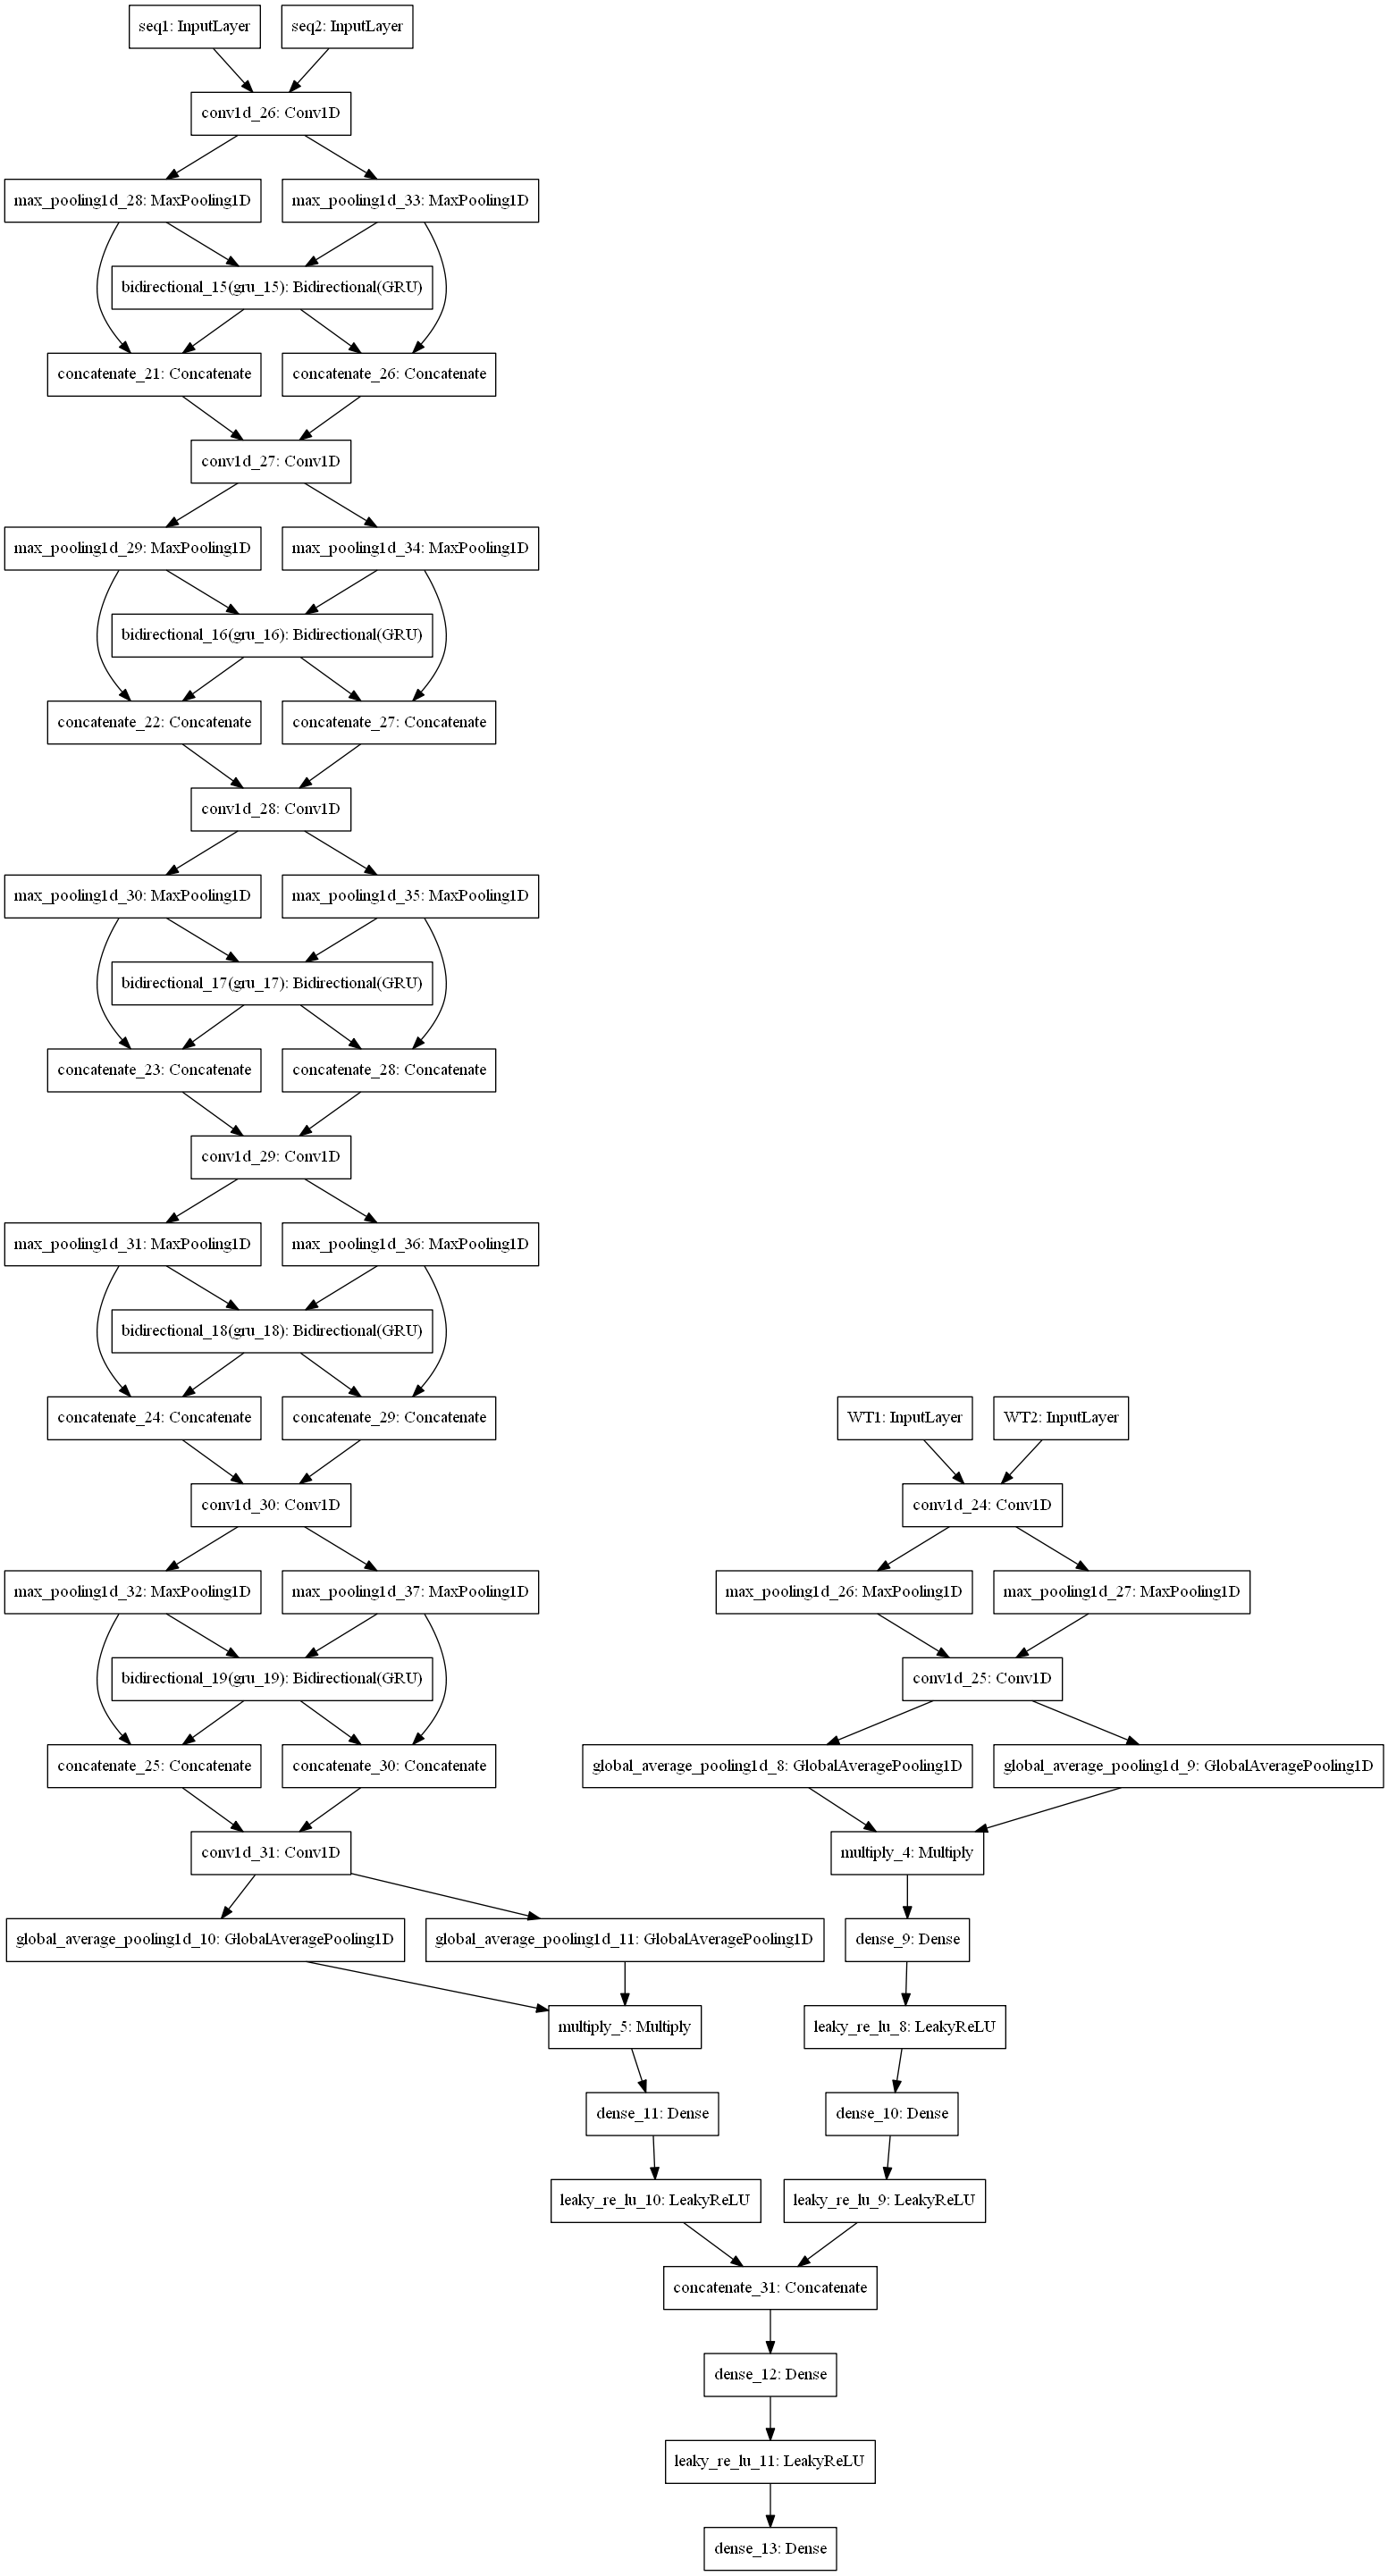

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(build_model())

In [15]:
print(build_model().summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq1 (InputLayer)               [(None, 600, 15)]    0                                            
__________________________________________________________________________________________________
seq2 (InputLayer)               [(None, 600, 15)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 598, 75)      3450        seq1[0][0]                       
                                                                 seq2[0][0]                       
__________________________________________________________________________________________________
max_pooling1d_14 (MaxPooling1D) (None, 199, 75)      0           conv1d_10[0][0]            

In [15]:
print(len(build_model().layers))

55


In [12]:
from sklearn.model_selection import KFold, ShuffleSplit
kf = KFold(n_splits=5, shuffle=True)
tries = 5
cur = 0
recalls = []
accuracy = []
total = []
total_truth = []
train_test = []
for train, test in kf.split(class_labels):
    if np.sum(class_labels[train], 0)[0] > 0.9 * len(train) or np.sum(class_labels[train], 0)[0] < 0.1 * len(train):
        continue
    train_test.append((train, test))
    cur += 1
    if cur >= tries:
        break

print (len(train_test))
print (len(train))
print (len(test))
print(len(class_labels))

5
58487
14621
73108


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
    #start_from_epoch=50
)
# Reduce_LR = ReduceLROnPlateau(
#     monitor='loss',
#     factor=0.1,
#     patience=100,
#     verbose=0,
#     mode='auto',
#     min_delta=0.0001,
#     min_lr=0.000001
# )
# lr_decayed_fn =  tf.keras.optimizers.schedules.CosineDecayRestarts(
#     0.001,
#     1000,
#         alpha=0.01
# )

In [ ]:
#copy below
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.
accuracy=[]
prec=[]
recall=[]
spec=[]
f1=[]
mcc=[]

n_epochs = 10
batch_size1 = 32

for train, test in train_test:
    merge_model = None
    merge_model = build_model()
    adam = Adam(learning_rate=0.001, amsgrad=True, epsilon=1e-6)
    TB = TensorBoard(log_dir=f'./logs/{str(datetime.datetime.now())[-9:]}', 
                 histogram_freq=0, 
                 write_graph=False)
    merge_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    merge_model.fit([seq_tensor[seq_index1[train]], seq_tensor[seq_index2[train]],T_W[seq_index1[train]], T_W[seq_index2[train]]], 
                    class_labels[train], 
                    batch_size=batch_size1, 
                    epochs=n_epochs,
                    validation_split=0.05,
                    callbacks=[early_stopping,TB]
   )

    #result1 = merge_model.evaluate([seq_tensor1[test], seq_tensor2[test]], class_labels[test])
    pred = merge_model.predict([seq_tensor[seq_index1[test]], seq_tensor[seq_index2[test]],T_W[seq_index1[test]], T_W[seq_index2[test]]])
    for i in range(len(class_labels[test])):
        num_total += 1
        if np.argmax(class_labels[test][i]) == np.argmax(pred[i]):
            num_hit += 1
        if class_labels[test][i][0] > 0.:
            num_pos += 1.
            if pred[i][0] > pred[i][1]:
                num_true_pos += 1
            else:
                num_false_neg += 1
        else:
            if pred[i][0] > pred[i][1]:
                num_false_pos += 1
            else:
                num_true_neg += 1
    accuracy.append(num_hit / num_total)
    prec.append(num_true_pos / (num_true_pos + num_false_pos))
    recall.append(num_true_pos / num_pos)
    spec.append(num_true_neg / (num_true_neg + num_false_neg))
    f1.append(2. * prec[-1] * recall[-1] / (prec[-1] + recall[-1]))
    mcc.append((num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_false_pos) * (num_true_pos + num_false_neg) * (num_false_neg + num_true_neg) * (num_true_neg + num_false_pos)) ** 0.5)
    print (accuracy[-1], prec[-1], recall[-1], spec[-1], f1[-1], mcc[-1])

Epoch 1/10
1737/1737 [==============================] - 152s 72ms/step - loss: 0.6897 - accuracy: 0.5382 - val_loss: 0.7344 - val_accuracy: 0.2506
Epoch 2/10
1737/1737 [==============================] - 120s 69ms/step - loss: 2.1859 - accuracy: 0.5863 - val_loss: 0.9375 - val_accuracy: 0.4031
Epoch 3/10
1737/1737 [==============================] - 121s 70ms/step - loss: 0.5524 - accuracy: 0.7115 - val_loss: 0.4962 - val_accuracy: 0.7870
Epoch 4/10
1737/1737 [==============================] - 121s 70ms/step - loss: 0.3476 - accuracy: 0.8490 - val_loss: 0.3130 - val_accuracy: 0.8896
Epoch 5/10
1737/1737 [==============================] - 121s 69ms/step - loss: 0.2497 - accuracy: 0.9012 - val_loss: 0.1900 - val_accuracy: 0.9439
Epoch 6/10
1737/1737 [==============================] - 120s 69ms/step - loss: 0.1747 - accuracy: 0.9362 - val_loss: 0.0912 - val_accuracy: 0.9805
Epoch 7/10
1737/1737 [==============================] - 121s 70ms/step - loss: 0.1389 - accuracy: 0.9516 - val_loss: 0

In [22]:
#accuracy = num_hit / num_total
#prec = num_true_pos / (num_true_pos + num_false_pos)
#recall = num_true_pos / num_pos
#spec = num_true_neg / (num_true_neg + num_false_neg)
#f1 = 2. * prec * recall / (prec + recall)
#mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
print ((sum(accuracy)/5),"+",np.std(accuracy),",", sum(prec)/5,"+",np.std(prec),",", sum(recall)/5,"+",np.std(recall),",", sum(spec)/5,"+",np.std(spec),",", sum(f1)/5,"+",np.std(f1),",", sum(mcc)/5,"+",np.std(mcc))
print (accuracy, prec, recall, spec, f1, mcc)

0.966169198689306 + 0.001376396406401815 , 0.9686864388570855 + 0.0014663202124933585 , 0.9628769021765905 + 0.0026129246828572664 , 0.9637254190402047 + 0.0026348995338330533 , 0.9657702129261061 + 0.0013743510689253448 , 0.9323509356042694 + 0.0027383326992595834
[0.9642537980339589, 0.9664879356568364, 0.9657432231158772, 0.9684986595174263, 0.9658623771224307] [0.9690909090909091, 0.9675090252707581, 0.9698431845597105, 0.9704679691049523, 0.9665211062590975] [0.9586330935251799, 0.9648964896489649, 0.9611476389719068, 0.9656419529837251, 0.964065335753176] [0.9595782073813708, 0.9654867256637168, 0.9617422012948793, 0.9665934065934066, 0.9652265542676501] [0.9638336347197106, 0.9662009914375845, 0.9654758330831582, 0.9680489462950373, 0.9652916590950391] [0.9285534068487936, 0.932974514016304, 0.9315209044809382, 0.9369965384230157, 0.9317093142522958]


In [17]:
tf.keras.backend.clear_session()


In [13]:
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.
accuracy=[]
prec=[]
recall=[]
spec=[]
f1=[]
mcc=[]
pred = merge_model.predict([seq_tensor[seq_index1[test]], seq_tensor[seq_index2[test]],T_W[seq_index1[test]], T_W[seq_index2[test]]])
for i in range(len(class_labels[test])):
    num_total += 1
    if np.argmax(class_labels[test][i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[test][i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1
        else:
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1
accuracy.append(num_hit / num_total)
prec.append(num_true_pos / (num_true_pos + num_false_pos))
recall.append(num_true_pos / num_pos)
spec.append(num_true_neg / (num_true_neg + num_false_neg))
f1.append(2. * prec[-1] * recall[-1] / (prec[-1] + recall[-1]))
mcc.append((num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_false_pos) * (num_true_pos + num_false_neg) * (num_false_neg + num_true_neg) * (num_true_neg + num_false_pos)) ** 0.5)
print (accuracy[-1], prec[-1], recall[-1], spec[-1], f1[-1], mcc[-1])

0.9801655153546269 0.976456178551987 0.9839550191991223 0.9839131032586278 0.980191256830601 0.9603597217494125


In [12]:
merge_model = tf.keras.models.load_model('saved_model/my_model2')

In [15]:
merge_model.save('saved_model/my_model2')

INFO:tensorflow:Assets written to: saved_model/my_model2\assets


INFO:tensorflow:Assets written to: saved_model/my_model2\assets
C:\Users\conda\anaconda3\envs\tf_2.6\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
